# Lab 6_4 GAN on CIFAR10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
# Hyperparameters
latent_dim = 100
batch_size = 1024
num_epochs = 10
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Training loop
for epoch in range(num_epochs):
    for images, _ in tqdm(train_loader):
        # Adversarial ground truths
        real_labels = torch.ones(images.size(0)).to(device)
        fake_labels = torch.zeros(images.size(0)).to(device)

        # Configure input
        real_images = images.to(device)

        # >>> Train Generator <<<
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(images.size(0), latent_dim, 1, 1).to(device)

        # Generate a batch of images
        gen_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_images), real_labels)

        g_loss.backward()
        optimizer_G.step()

        # >>> Train Discriminator <<<
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(gen_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # Print progress
    if (epoch == num_epochs-1):
      print()
    print(f"Epoch [{epoch+1}/{num_epochs}], D_Loss(in last batch): {d_loss.item():.4f}, G_Loss(in last batch): {g_loss.item():.4f}")

100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


Epoch [1/10], D_Loss(in last batch): 0.0182, G_Loss(in last batch): 4.0374


100%|██████████| 49/49 [00:42<00:00,  1.16it/s]


Epoch [2/10], D_Loss(in last batch): 0.0053, G_Loss(in last batch): 4.9447


100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


Epoch [3/10], D_Loss(in last batch): 0.2105, G_Loss(in last batch): 19.0884


100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


Epoch [4/10], D_Loss(in last batch): 0.1384, G_Loss(in last batch): 2.6064


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch [5/10], D_Loss(in last batch): 0.0996, G_Loss(in last batch): 2.8525


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch [6/10], D_Loss(in last batch): 0.2664, G_Loss(in last batch): 1.7728


100%|██████████| 49/49 [00:43<00:00,  1.11it/s]


Epoch [7/10], D_Loss(in last batch): 0.2708, G_Loss(in last batch): 1.3734


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch [8/10], D_Loss(in last batch): 0.2667, G_Loss(in last batch): 1.6909


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


Epoch [9/10], D_Loss(in last batch): 0.6660, G_Loss(in last batch): 2.5701


100%|██████████| 49/49 [00:44<00:00,  1.11it/s]



Epoch [10/10], D_Loss(in last batch): 0.2921, G_Loss(in last batch): 2.2733


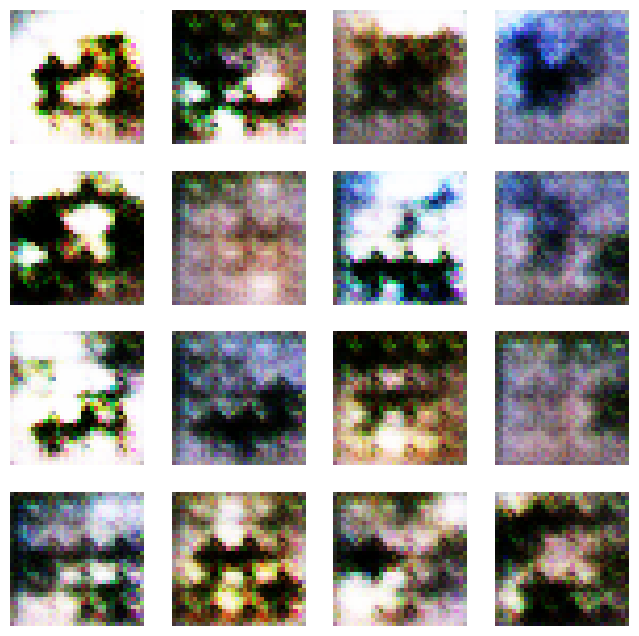

In [ ]:
# Generate and display images after training
num_test_samples = 16
with torch.no_grad():
    z = torch.randn(num_test_samples, latent_dim, 1, 1).to(device)
    generated_images = generator(z).detach().cpu()

# Display generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and display
    ax.axis('off')
plt.show()

---